In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [5]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [8]:
with open('stopwords.txt', encoding='utf8') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [9]:
def clean_text(text):
    '''
    очистка текста

    на выходе очищеный текст

    '''
    if not isinstance(text, str):
        text = str(text)

    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())

    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]

    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)

    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)

    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]

    return words_lem_without_stopwords

In [10]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-9-33395cc7086c>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 25.2 s


In [11]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min 19s


А теперь в 3 строчки обучим нашу модель

In [12]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, тропический, углеродный, цикл, чув...
26999    [жить, примерно, тыс, назад, территория, совре...
Name: title, Length: 27000, dtype: object

In [13]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [14]:
common_dictionary[10]

'ватутин'

Запускаем обучение

In [16]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 47.3 s


In [17]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [18]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc]

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(4, 0.35206854), (16, 0.29027912), (18, 0.09209381), (19, 0.2432832)]

In [19]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: болезнь германия немецкий индия святой лагерь берлин
topic_1: россия развитие nn путин население метод участник
topic_2: млн рост проект млрд рубль цена новый
topic_3: россия российский государство глава население вопрос технология
topic_4: всё научный газета очень большой наука проблема
topic_5: ракета журнал тело смерть университет риск тыс
topic_6: сша гражданин американский инвестиция блок белый вицепремьер
topic_7: украина украинский киев военный украинец польша иран
topic_8: всё день nnn дональд кремль ребёнок чёрный
topic_9: nn область район погибнуть военный произойти россия
topic_10: станция москва мозг рак агентство центр день
topic_11: миссия рейс соцсеть аэропорт израиль израильский кит
topic_12: век рекомендовать парк отреагировать рекорд сезон понятие
topic_13: иск испытание девочка лекарство подать негативно компенсация
topic_14: эксперт российский исследование северный nn помощь пациент
topic_15: космос методика грунт гражданство праздничный гагарин передовой
t

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [20]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [21]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.822631,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.052445,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.103601
1,4896,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.249063,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
2,4897,0.0,0.000000,0.000000,0.0,0.352114,0.0,0.0,0.0,0.000000,...,0.0,0.290286,0.000000,0.091982,0.243343,0.000000,0.0,0.0,0.0,0.000000
3,4898,0.0,0.000000,0.060593,0.0,0.265027,0.0,0.0,0.0,0.091177,...,0.0,0.156495,0.000000,0.000000,0.000000,0.028804,0.0,0.0,0.0,0.000000
4,4899,0.0,0.240158,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.093797,0.159839,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [22]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [23]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [24]:
doc_dict[293622]

array([0.        , 0.20661817, 0.        , 0.        , 0.05381859,
       0.03660382, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.07986505, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.20176074,
       0.23935676, 0.16974491, 0.        , 0.        , 0.        ])

In [25]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [26]:
get_user_embedding(user_articles_list)

array([0.        , 0.06537835, 0.0566064 , 0.18532034, 0.14121367,
       0.05848921, 0.0691646 , 0.03222061, 0.        , 0.00611958,
       0.        , 0.        , 0.        , 0.        , 0.09742122,
       0.00444731, 0.        , 0.01142419, 0.        , 0.05426882,
       0.01259077, 0.17154615, 0.01683074, 0.        , 0.00224494])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [27]:
#users['articles'].iloc[33]

In [28]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [29]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.159182,0.100057,0.086367,0.017313,0.034695,0.021308,0.046588,0.035515,...,0.000000,0.0,0.000000,0.006568,0.048728,0.066511,0.078719,0.038049,0.0,0.022866
1,u108690,0.011724,0.078020,0.061368,0.107109,0.150755,0.031879,0.033675,0.051880,0.070338,...,0.001876,0.0,0.015002,0.000000,0.067437,0.000000,0.124903,0.005831,0.0,0.003643
2,u108339,0.000000,0.088522,0.022796,0.088030,0.047411,0.039021,0.008277,0.002989,0.062289,...,0.000000,0.0,0.004443,0.000000,0.063955,0.000000,0.166886,0.025519,0.0,0.045254


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [30]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [31]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.159182,0.100057,0.086367,0.017313,0.034695,0.021308,0.046588,0.035515,...,0.0,0.000000,0.006568,0.048728,0.066511,0.078719,0.038049,0.0,0.022866,0
1,u108690,0.011724,0.078020,0.061368,0.107109,0.150755,0.031879,0.033675,0.051880,0.070338,...,0.0,0.015002,0.000000,0.067437,0.000000,0.124903,0.005831,0.0,0.003643,1
2,u108339,0.000000,0.088522,0.022796,0.088030,0.047411,0.039021,0.008277,0.002989,0.062289,...,0.0,0.004443,0.000000,0.063955,0.000000,0.166886,0.025519,0.0,0.045254,1


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [33]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]],
                                                    X['churn'], random_state=0)

In [34]:
logreg = LogisticRegression()
#обучим
logreg.fit(X_train, y_train)

LogisticRegression()

In [35]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.14538023, 0.10705327, 0.42351985, 0.22609427, 0.0274082 ,
       0.05421406, 0.21817271, 0.04050282, 0.16631168, 0.11074675])

In [36]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [37]:
import itertools

In [38]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.272887, F-Score=0.736, Precision=0.693, Recall=0.784


In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1670   85]
 [  54  191]]


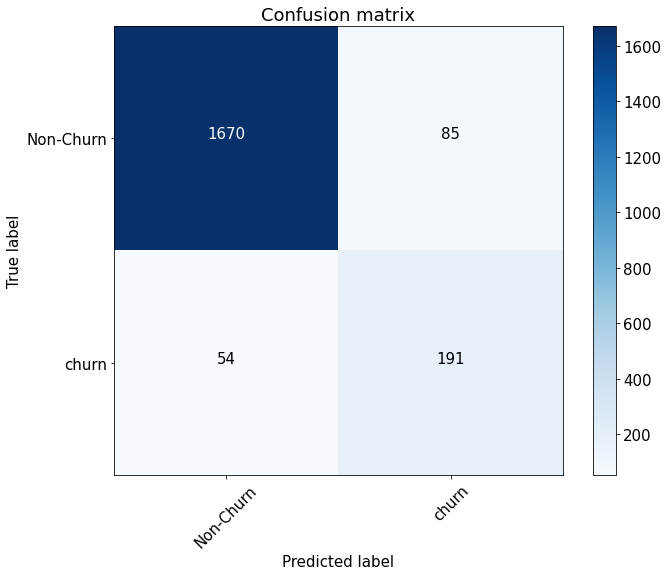

In [40]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [42]:
roc = roc_auc_score(y_test, preds)
roc

0.9594464794464794

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [52]:
# Сначала создадим таблицу для сравнения и внесем уже посчитанные метрики
results = pd.DataFrame({"Score": ["Roc Auc","F-Score", "Precision", "Recall"],"Mean": [roc, fscore[ix], precision[ix], recall[ix]]})
results.set_index("Score", drop=True, inplace=True)

In [54]:
# модифицируем код, чтобы получить медиану
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [55]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.205861,0.000000,0.049575,0.000000,0.018302,0.000000,0.000000,0.014220,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.048851,0.0,0.0,0.000000
1,u108690,0.007226,0.062346,0.010159,0.085863,0.153885,0.015669,0.010036,0.020357,0.073787,...,0.0,0.0,0.017377,0.0,0.056413,0.0,0.117064,0.0,0.0,0.000000
2,u108339,0.000000,0.065583,0.007826,0.087368,0.027023,0.038368,0.000000,0.000000,0.057523,...,0.0,0.0,0.000000,0.0,0.059102,0.0,0.175271,0.0,0.0,0.019824


In [56]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.205861,0.000000,0.049575,0.000000,0.018302,0.000000,0.000000,0.014220,...,0.0,0.000000,0.0,0.000000,0.0,0.048851,0.0,0.0,0.000000,0
1,u108690,0.007226,0.062346,0.010159,0.085863,0.153885,0.015669,0.010036,0.020357,0.073787,...,0.0,0.017377,0.0,0.056413,0.0,0.117064,0.0,0.0,0.000000,1
2,u108339,0.000000,0.065583,0.007826,0.087368,0.027023,0.038368,0.000000,0.000000,0.057523,...,0.0,0.000000,0.0,0.059102,0.0,0.175271,0.0,0.0,0.019824,1


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]],
                                                    X['churn'], random_state=0)

In [58]:
logreg = LogisticRegression()
#обучим
logreg.fit(X_train, y_train)

LogisticRegression()

In [59]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.18421617, 0.01027788, 0.48816407, 0.22100234, 0.01919225,
       0.00853464, 0.135162  , 0.06452399, 0.0532544 , 0.21213719])

In [60]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.285515, F-Score=0.833, Precision=0.779, Recall=0.894


In [61]:
roc = roc_auc_score(y_test, preds)
roc

0.9823896738182452

In [62]:
results["Median"] = [roc, fscore[ix], precision[ix], recall[ix]]
results

,Mean,Median
Score,,
Roc Auc,0.959446,0.982390
F-Score,0.735632,0.832700
Precision,0.693141,0.779359
Recall,0.783673,0.893878


3. Повторить п.2, но используя уже не медиану, а max

In [63]:
# модифицируем код, чтобы получить максимальное значение
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [64]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.315335,0.361719,0.227724,0.053819,0.108949,0.127850,0.279528,0.150883,...,0.000000,0.0,0.000000,0.039409,0.201761,0.239357,0.204869,0.162682,0.0,0.111653
1,u108690,0.037739,0.268430,0.221726,0.213358,0.309538,0.116986,0.119651,0.136292,0.168161,...,0.011259,0.0,0.027785,0.000000,0.162379,0.000000,0.248247,0.019173,0.0,0.021858
2,u108339,0.000000,0.225561,0.096851,0.226554,0.118841,0.087026,0.049662,0.017932,0.120975,...,0.000000,0.0,0.026655,0.000000,0.131099,0.000000,0.270678,0.141257,0.0,0.193260


In [65]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.315335,0.361719,0.227724,0.053819,0.108949,0.127850,0.279528,0.150883,...,0.0,0.000000,0.039409,0.201761,0.239357,0.204869,0.162682,0.0,0.111653,0
1,u108690,0.037739,0.268430,0.221726,0.213358,0.309538,0.116986,0.119651,0.136292,0.168161,...,0.0,0.027785,0.000000,0.162379,0.000000,0.248247,0.019173,0.0,0.021858,1
2,u108339,0.000000,0.225561,0.096851,0.226554,0.118841,0.087026,0.049662,0.017932,0.120975,...,0.0,0.026655,0.000000,0.131099,0.000000,0.270678,0.141257,0.0,0.193260,1


In [66]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]],
                                                    X['churn'], random_state=0)

In [67]:
logreg = LogisticRegression()
#обучим
logreg.fit(X_train, y_train)

LogisticRegression()

In [68]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.26708848, 0.00454427, 0.66520191, 0.08500338, 0.02590448,
       0.03975762, 0.12895589, 0.0291532 , 0.06511904, 0.07769922])

In [69]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.317775, F-Score=0.820, Precision=0.773, Recall=0.873


In [70]:
roc = roc_auc_score(y_test, preds)
roc

0.9795685795685796

In [71]:
results["Max"] = [roc, fscore[ix], precision[ix], recall[ix]]
results

,Mean,Median,Max
Score,,,
Roc Auc,0.959446,0.982390,0.979569
F-Score,0.735632,0.832700,0.819923
Precision,0.693141,0.779359,0.772563
Recall,0.783673,0.893878,0.873469
